# NLP_Project_Text_Summarization
Project by Urani JEAN-LOUIS and Appanna MACHIMANDA

### Importing the dataset
The PubAg dataset has to be uploaded into Google Drive and the path can be pasted as '/content/gdrive/My Drive/Colab Notebooks/PubAg.json'. Where 'My Drive' is the root folder of your google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/PubAg.json', 'r') as f:
  abstract_dict = json.load(f)

In [ ]:
abstract_df = pd.DataFrame.from_dict(abstract_dict)
abstract_df.head()
#len(abstract_df['abstracts']) # 83,799 abstracts

#Use a small subsection for testing algo:
sliced_abs=abstract_df.head(100)
#sliced_abs


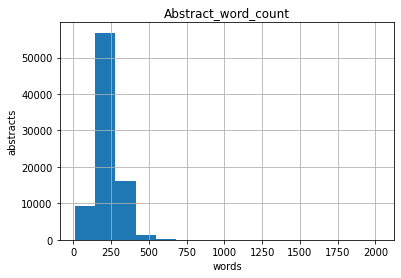

In [ ]:
#Distribution of words
abstracts_word_count = []
for i in abstract_df['abstracts']:
    abstracts_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Abstract_word_count': abstracts_word_count})
length_df.hist(bins=15)
plt.xlabel('words')
plt.ylabel('abstracts')
plt.savefig("PubAg_dist.jpg") # save as png
plt.show()

In [ ]:
length_df.describe() #Most of the abstracts have less than 189 words

,Abstract_word_count
count,83799.000000
mean,228.174083
std,76.789850
min,10.000000
25%,178.000000
50%,222.000000
75%,267.000000
max,2025.000000


In [ ]:
%%time
#Tokenize abstract into its constituent sentences
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
sentences = []
for s in abstract_df['abstracts']: #for each abstract in the column
  sentences.append(sent_tokenize(s))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 36.7 s, sys: 386 ms, total: 37 s
Wall time: 37.1 s


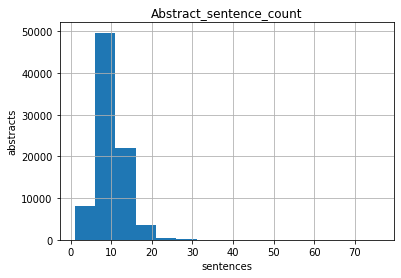

In [ ]:
len(sentences[0])#number of sentences in abstract 0.

##Distribution of sentences
abstracts_sent_count = []
abstract_df['num_sents']=""
for ind,i in enumerate(sentences):
    abstracts_sent_count.append(len(i))
    abstract_df['num_sents'][ind]=len(i) #Create new column with number of sentences
abstract_df['num_sents'] = pd.to_numeric(abstract_df['num_sents']) #conver the column to numeric

length_sent = pd.DataFrame({'Abstract_sentence_count': abstracts_sent_count})
length_sent.hist(bins=15)
plt.xlabel('sentences')
plt.ylabel('abstracts')
plt.savefig("PubAg_dist.jpg") # save as png
plt.show()

In [ ]:
length_sent.describe() #Most of the abstracts have less than 189 words

,Abstract_sentence_count
count,83799.000000
mean,9.347797
std,3.409347
min,1.000000
25%,7.000000
50%,9.000000
75%,11.000000
max,76.000000


In [ ]:
#Create column with word length
abstract_df['num_words']=abstract_df['abstracts'].apply( lambda x:len(x.split()))

#Create column with sentence length


#Max length of sentence in the dataset
abstract_df['abstracts'].apply( lambda x:len(x.split())).max()

#Dataframe of max value
#df.loc[df['num_words']==df['num_words'].max()]


len(abstract_df)
#abstract_df.head()

83799

## Set dataframe with:
  - Number of abstracts to run algorithms
  - Custom dataframe rows


In [ ]:
#df is referenced throughout the rest of the code

#Can create custom dataaframe with selected dataframe to run inference.
#index loc of max sents 

##Custom dataset mix
# df=abstract_df.head(8) # to set for first 8 abstracts
# max_words_index = abstract_df['num_words'].idxmax() 
# max_sents_index = abstract_df['num_sents'].idxmax() 
# df=df.append(abstract_df.loc[max_words_index]) #Add row with max words
# df=df.append(abstract_df.loc[max_sents_index]) #Add row with max sentences
# df.reset_index(inplace=True,drop=True)
##Custom dataset mix

df=abstract_df.head(100) # to set for first 'n' abstracts
df

,titles,abstracts,authors,keywords,sources,dates,num_sents,num_words
0,Examining the social and biophysical determina...,Precision agricultural technologies (PA) such ...,"[Gardezi, Maaz, Bronson, Kelly]","[corn, farmers, financial economics, food prod...",Precision agriculture,2020,6,198
1,Wireless Sensor Network Synchronization for Pr...,The advent of Internet of Things has propelled...,"[Zervopoulos, Alexandros, Tsipis, Athanasios, ...","[Olea europaea, decision making, environmental...",Agriculture (Basel),2020,9,197
2,Smartphone Applications Targeting Precision Ag...,Traditionally farmers have used their perceptu...,"[Mendes, Jorge, Pinho, Tatiana M., Neves dos ...","[cost effectiveness, crops, farmers, humans, m...",Agronomy,2020,9,216
3,Controlled release micronutrient fertilizers f...,The rapid growth of the global population and ...,"[Mikula, Katarzyna, Izydorczyk, Grzegorz, Skrz...","[coatings, farmers, food safety, groundwater, ...",The Science of the total environment,2020,8,159
4,Farm adoption of embodied knowledge and inform...,On-farm adoption of individual and groups of p...,"[Miller, N. J., Griffin, T. W., Ciampitti, I. ...","[farms, precision agriculture, probability, Ka...",Precision agriculture,2019,6,152
...,...,...,...,...,...,...,...,...
95,Golf course superintendents’ knowledge of vari...,Golf course superintendent’s knowledge of vari...,"[Straw, Chase M., Wardrop, William S., Horgan,...","[case studies, geographic information systems,...",Precision agriculture,2020,10,247
96,Performance evaluation of automatic vis-à-vis ...,Laser land levelling has contributed immensely...,"[Manpreet-Singh,, Sidhu, Harminder S., Yadvind...","[cost effectiveness, energy use and consumptio...",Precision agriculture,2020,13,267
97,Agricultural cyber-physical system enabled for...,"Recently, several works have been focused on d...","[Selmani, Abdelouahed, Oubehar, Hassan, Outano...","[case studies, greenhouses, irrigation managem...",Biosystems engineering,2019,9,195
98,Precision conservation meets precision agricul...,Meeting future food demands for 9 billion peop...,"[Capmourteres, Virginia, Adams, Justin, Berg, ...","[agricultural land, biodiversity, case studies...",Agricultural systems,2018,8,240


## Extractive_TextRank

###Imports and tokenization

In [ ]:
%%time
import nltk
nltk.download('punkt') # one time execution
nltk.download('stopwords')


#!pip install --user -U nltk
from nltk.tokenize import sent_tokenize

import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 3.45 ms, sys: 0 ns, total: 3.45 ms
Wall time: 3.56 ms


In [ ]:
#df['abstracts'][0]
len(df['abstracts'])

100

In [ ]:
#Tokenize full abstract dataset into its constituent sentences
%%time
#walltime 39.7s for all abstracts(full dataset).  Average 2000 abstracs per sec
#from nltk.tokenize import sent_tokenize


#Select which dataframe to use here. Either abstract_df or sliced_df
#df=abstract_df

sentences = []
for s in df['abstracts']: #for each abstract in the column
  sentences.append(sent_tokenize(s))

CPU times: user 141 ms, sys: 14 ms, total: 155 ms
Wall time: 157 ms


In [ ]:
sentences[0]

['Precision agricultural technologies (PA) such as global positioning system tools have been commercially available since the early 1990s and they are widely thought to have environmental and economic benefit; however, adoption studies show uneven adoption among farmers in the U.S. and Europe.',
 'This study aims to tackle a lingering puzzle regarding why some farmers adopt precision agriculture as an approach to food production and why others do not.',
 'The specific objective of this study is to examine the social and biophysical determinants of farmers’ adoption of PA.',
 'This paper fills a research gap by including measurements of farmer identity—specifically their own conceptions of their role in the food system—as well as their perceptions of biophysical risks as these relate to the adoption of PA among a large sample of Midwestern U.S. farmers.',
 'The study has identified that farmer identity and perceptions of environmental risk do indeed influence PA adoption and that these 

In [ ]:
#sentences[0]

#### Downloaded GloVe word embeddings.
Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. https://machinelearningmastery.com/what-are-word-embeddings/

In [ ]:
%%time
# Extract word vectors 9.6s for glove 100d. For 1000 abs 9.45s
word_embeddings = {}
f = open('/content/gdrive/My Drive/Colab Notebooks/glove.6B/glove.6B.100d.txt', encoding='utf-8')
for line in f: # Each line refers to a word and its corresponding vector weights
    values = line.split() #list of word and the weights
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

CPU times: user 10.8 s, sys: 348 ms, total: 11.1 s
Wall time: 11.4 s


In [ ]:
len(word_embeddings) #Number of words
#word_embeddings.loc[0]

400000

#### Text pre-processing

In [ ]:
%%time
#14min 12 secs,13min 14s for full dataset
#6.85s for 1000 

# remove punctuations, numbers and special characters
# For clean_sents[0] need to get all the sents of abstract 1


clean_sentences=[] #list of abstracts
for each_abs in sentences:
    sublists=[]
    for sents in each_abs:
        a = sents.lower()
        b = pd.Series(a).str.replace("[^a-zA-Z]", " ") #replace anything which is not a-zA-Z; numbers,special characters etc.
        #b = a.str.lower()
        sublists.append(str(b))
    clean_sentences.append(sublists)

CPU times: user 796 ms, sys: 24 ms, total: 820 ms
Wall time: 798 ms


In [ ]:
clean_sentences[0]

['0    precision agricultural technologies  pa  such ...\ndtype: object',
 '0    this study aims to tackle a lingering puzzle r...\ndtype: object',
 '0    the specific objective of this study is to exa...\ndtype: object',
 '0    this paper fills a research gap by including m...\ndtype: object',
 '0    the study has identified that farmer identity ...\ndtype: object',
 '0    the findings also appear to highlight the soci...\ndtype: object']

In [ ]:

#Remove stopwords

#stop_words = stopwords.words('english') #from ntlk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('english')
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new





In [ ]:
# remove stopwords from the sentences
#For 1000 abs 214 ms
%%time

clean_sents2=[]
for each_abs in clean_sentences:
    sublists=[]
    for sents in each_abs: #for each sentence in the each abstract
        a= remove_stopwords(sents.split())
        sublists.append(a)
    clean_sents2.append(sublists)

clean_sentences=clean_sents2
print(clean_sentences[0][0])

0 precision agricultural technologies pa ... dtype: object
CPU times: user 26.1 ms, sys: 12 µs, total: 26.1 ms
Wall time: 27.2 ms


In [ ]:
clean_sentences[0]

['0 precision agricultural technologies pa ... dtype: object',
 '0 study aims tackle lingering puzzle r... dtype: object',
 '0 specific objective study exa... dtype: object',
 '0 paper fills research gap including m... dtype: object',
 '0 study identified farmer identity ... dtype: object',
 '0 findings also appear highlight soci... dtype: object']

### Sentence Vectors
Each sentence has to have a sentence vector. But all sentences of a particular abstract should also be grouped(within a list). This allows similarity matrix to be prepared for each abstract and assign score for sentences within its own abstract.

In [ ]:
# fetch vectors (each of size 100 elements) for the constituent words in a sentence.
# Because each word has 100 coeffs in the gloVe 100d word embeddings.
# Take mean/average of those vectors to arrive at a consolidated vector for the sentence.
# This means that the coeffs for each word are summed for the sentence. Averaged for sentence so that salient words/themes in the sentence can be identified.
%%time
#138ms for 1000 abstracts
sentence_vectors_outer = []
for each_abs in clean_sentences:
    sentence_vectors_inner = [] #Define an inner list to capture sentences for each abstract.
    for sents in each_abs:
        if len(sents) != 0:
            v = sum([word_embeddings.get(w, np.zeros((100,))) for w in sents.split()])/(len(sents.split())+0.001) #get coeffs for word; default to zeros (in.get) if word not present in word_embeddings dict
        else:
            v = np.zeros((100,))
        sentence_vectors_inner.append(v)
    sentence_vectors_outer.append(sentence_vectors_inner)

CPU times: user 22.4 ms, sys: 11 µs, total: 22.4 ms
Wall time: 24.3 ms


In [ ]:
#sentence_vectors_outer[0][0] #First sentence of the first abstract

### Similarity Matrix Preparation
The next step is to find similarities between the sentences, and we will use the cosine similarity approach for this challenge. Let’s create an empty similarity matrix for this task and populate it with cosine similarities of the sentences.

For multiple abstracts, we should consider similarities within the abstract. So the shape of similarity mat will depend on number of sentences within each of the abstracts.

In [ ]:
%%time
#113microsecs for 5
#12.3ms for 1000
sim_mat_inner = []
for each_abs in clean_sentences:
    for sents in each_abs:
        sim_mat = np.zeros([len(each_abs), len(each_abs)])
    sim_mat_inner.append(sim_mat)  

CPU times: user 1.43 ms, sys: 0 ns, total: 1.43 ms
Wall time: 1.85 ms


In [ ]:
#sim_mat_inner[0]

In [ ]:
%%time
#from sklearn.metrics.pairwise import cosine_similarity
#411ms for 5
#3m23s for 1000
#22.2s for 100

#All models sequntial in 1 shot. To avoid differences in runtime.
#1.87s for 10 Colab with GPU
#15.9 for 100

for ind,each_abs in enumerate(clean_sentences): # to use index of a list we should use 'enumerate'
    for sents in each_abs:
        for i in range(len(each_abs)): #len(sents) is the number of sentences. sim_mat_out has been initialised to this 
            for j in range(len(each_abs)):
                if i != j: #diagonal remains 0 because it compares sentence with itself
                    sim_mat_inner[ind][i][j] = cosine_similarity(sentence_vectors_outer[ind][i].reshape(1,100), sentence_vectors_outer[ind][j].reshape(1,100))[0,0]
        #sim_mat_outer.append(sim_mat_inner)

CPU times: user 16.3 s, sys: 695 ms, total: 17 s
Wall time: 15.9 s


### Applying PageRank algorithm as TextRank

In [ ]:
%%time
#import networkx as nx

score_list=[]
for ind, each_abs in enumerate(clean_sentences):
    nx_graph = nx.from_numpy_array(sim_mat_inner[ind])
    scores = nx.pagerank(nx_graph) #score is dict with key as sent and value as score.
    score_list.append(scores)

CPU times: user 149 ms, sys: 3.03 ms, total: 152 ms
Wall time: 153 ms


In [ ]:
score_list[0]

{0: 0.1578701090600545,
 1: 0.16484575234929832,
 2: 0.17202576739350708,
 3: 0.16994174502791834,
 4: 0.16791917665638473,
 5: 0.16739744951283703}

### Summary Extraction

In [ ]:
%%time
#11.2ms for 1000
#Note how here we have used 'sentences' to reference the original sentences

ranked_sent_list=[]
for ind1,each_abs in enumerate(sentences): 
    ranked_sublist=[]
    for ind2,sents in enumerate(each_abs):
        a=(score_list[ind1][ind2],sents)
        ranked_sublist.append(a)
    ranked_sent_list.append(sorted(ranked_sublist,reverse=True))

CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 1.55 ms


In [ ]:
#ranked_sent_list[999]
len(sentences[0])

6

In [ ]:
%%time
# 73.9 ms for 1000
# Extract top 3 sentences of each abstract as the summary. Add to a new column in the sliced dataframe
df['ext_textrank']=""
for ind1,each_abs in enumerate(sentences):
    #print("\nSummary of Abstract : ", ind1)
    new_sum=""
    if len(each_abs)>2:
      for i in range(3):
          new_sum +=ranked_sent_list[ind1][i][1]+' '
          #print(ranked_sent_list[ind1][i][1])
    else:
      for i in range(len(each_abs)):
          new_sum +=ranked_sent_list[ind1][i][1]+' '


    df['ext_textrank'][ind1]= new_sum
    

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 24.2 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/IPython/core/magics/execution.py:1193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [ ]:
df

,titles,abstracts,authors,keywords,sources,dates,num_sents,num_words,ext_textrank
0,Examining the social and biophysical determina...,Precision agricultural technologies (PA) such ...,"[Gardezi, Maaz, Bronson, Kelly]","[corn, farmers, financial economics, food prod...",Precision agriculture,2020,6,198,The specific objective of this study is to exa...
1,Wireless Sensor Network Synchronization for Pr...,The advent of Internet of Things has propelled...,"[Zervopoulos, Alexandros, Tsipis, Athanasios, ...","[Olea europaea, decision making, environmental...",Agriculture (Basel),2020,9,197,"For example, a need for network synchronizatio..."
2,Smartphone Applications Targeting Precision Ag...,Traditionally farmers have used their perceptu...,"[Mendes, Jorge, Pinho, Tatiana M., Neves dos ...","[cost effectiveness, crops, farmers, humans, m...",Agronomy,2020,9,216,"Also, this paper is an important resource to h..."
3,Controlled release micronutrient fertilizers f...,The rapid growth of the global population and ...,"[Mikula, Katarzyna, Izydorczyk, Grzegorz, Skrz...","[coatings, farmers, food safety, groundwater, ...",The Science of the total environment,2020,8,159,The paper presents new fertilization technolog...
4,Farm adoption of embodied knowledge and inform...,On-farm adoption of individual and groups of p...,"[Miller, N. J., Griffin, T. W., Ciampitti, I. ...","[farms, precision agriculture, probability, Ka...",Precision agriculture,2019,6,152,Each analysis was estimated for two separate t...
...,...,...,...,...,...,...,...,...,...
95,Golf course superintendents’ knowledge of vari...,Golf course superintendent’s knowledge of vari...,"[Straw, Chase M., Wardrop, William S., Horgan,...","[case studies, geographic information systems,...",Precision agriculture,2020,10,247,This case study used a qualitative GIS approac...
96,Performance evaluation of automatic vis-à-vis ...,Laser land levelling has contributed immensely...,"[Manpreet-Singh,, Sidhu, Harminder S., Yadvind...","[cost effectiveness, energy use and consumptio...",Precision agriculture,2020,13,267,The automatic survey method significantly redu...
97,Agricultural cyber-physical system enabled for...,"Recently, several works have been focused on d...","[Selmani, Abdelouahed, Oubehar, Hassan, Outano...","[case studies, greenhouses, irrigation managem...",Biosystems engineering,2019,9,195,"Therefore, a variety of ACPSs has been develop..."
98,Precision conservation meets precision agricul...,Meeting future food demands for 9 billion peop...,"[Capmourteres, Virginia, Adams, Justin, Berg, ...","[agricultural land, biodiversity, case studies...",Agricultural systems,2018,8,240,We argue that profit mapping can serve as a ma...


## Extractive_BERTSUM

In [ ]:
df.head()

,titles,abstracts,authors,keywords,sources,dates,num_sents,num_words,ext_textrank
0,Examining the social and biophysical determina...,Precision agricultural technologies (PA) such ...,"[Gardezi, Maaz, Bronson, Kelly]","[corn, farmers, financial economics, food prod...",Precision agriculture,2020,6,198,The specific objective of this study is to exa...
1,Wireless Sensor Network Synchronization for Pr...,The advent of Internet of Things has propelled...,"[Zervopoulos, Alexandros, Tsipis, Athanasios, ...","[Olea europaea, decision making, environmental...",Agriculture (Basel),2020,9,197,"For example, a need for network synchronizatio..."
2,Smartphone Applications Targeting Precision Ag...,Traditionally farmers have used their perceptu...,"[Mendes, Jorge, Pinho, Tatiana M., Neves dos ...","[cost effectiveness, crops, farmers, humans, m...",Agronomy,2020,9,216,"Also, this paper is an important resource to h..."
3,Controlled release micronutrient fertilizers f...,The rapid growth of the global population and ...,"[Mikula, Katarzyna, Izydorczyk, Grzegorz, Skrz...","[coatings, farmers, food safety, groundwater, ...",The Science of the total environment,2020,8,159,The paper presents new fertilization technolog...
4,Farm adoption of embodied knowledge and inform...,On-farm adoption of individual and groups of p...,"[Miller, N. J., Griffin, T. W., Ciampitti, I. ...","[farms, precision agriculture, probability, Ka...",Precision agriculture,2019,6,152,Each analysis was estimated for two separate t...


In [ ]:
len(df) #Number of abstracts considered

100

In [ ]:
!pip install bert-extractive-summarizer
!pip install sentencepiece

In [ ]:
from summarizer import Summarizer

model = Summarizer()

#Only works if sufficient resources have been allocated in google colab

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
## Test on the first abstract
%%time
model(df['abstracts'][0])

CPU times: user 4.74 s, sys: 32.1 ms, total: 4.77 s
Wall time: 4.87 s


'Precision agricultural technologies (PA) such as global positioning system tools have been commercially available since the early 1990s and they are widely thought to have environmental and economic benefit; however, adoption studies show uneven adoption among farmers in the U.S. and Europe. The findings also appear to highlight the social force of policy and industry efforts to frame PA as not only good for productivity and efficiency but also as an ecologically beneficial technology.'

In [ ]:
#Function to apply on full dataframe
def bertsum(text): #pass in the dataframe
    bertsum=model(text)
    return bertsum

In [ ]:
%%time
#df=abstract_df.head(5) #Try to implement for subset of the dataframe

#Time for 10 abs 59.1s
#9m49s for 100
df['ext_bertsum']= df['abstracts'].apply(lambda x: bertsum(x))

CPU times: user 9min 47s, sys: 9.02 s, total: 9min 56s
Wall time: 9min 49s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df

,titles,abstracts,authors,keywords,sources,dates,num_sents,num_words,ext_textrank,ext_bertsum
0,Examining the social and biophysical determina...,Precision agricultural technologies (PA) such ...,"[Gardezi, Maaz, Bronson, Kelly]","[corn, farmers, financial economics, food prod...",Precision agriculture,2020,6,198,The specific objective of this study is to exa...,Precision agricultural technologies (PA) such ...
1,Wireless Sensor Network Synchronization for Pr...,The advent of Internet of Things has propelled...,"[Zervopoulos, Alexandros, Tsipis, Athanasios, ...","[Olea europaea, decision making, environmental...",Agriculture (Basel),2020,9,197,"For example, a need for network synchronizatio...",The advent of Internet of Things has propelled...
2,Smartphone Applications Targeting Precision Ag...,Traditionally farmers have used their perceptu...,"[Mendes, Jorge, Pinho, Tatiana M., Neves dos ...","[cost effectiveness, crops, farmers, humans, m...",Agronomy,2020,9,216,"Also, this paper is an important resource to h...",Traditionally farmers have used their perceptu...
3,Controlled release micronutrient fertilizers f...,The rapid growth of the global population and ...,"[Mikula, Katarzyna, Izydorczyk, Grzegorz, Skrz...","[coatings, farmers, food safety, groundwater, ...",The Science of the total environment,2020,8,159,The paper presents new fertilization technolog...,The rapid growth of the global population and ...
4,Farm adoption of embodied knowledge and inform...,On-farm adoption of individual and groups of p...,"[Miller, N. J., Griffin, T. W., Ciampitti, I. ...","[farms, precision agriculture, probability, Ka...",Precision agriculture,2019,6,152,Each analysis was estimated for two separate t...,On-farm adoption of individual and groups of p...
...,...,...,...,...,...,...,...,...,...,...
95,Golf course superintendents’ knowledge of vari...,Golf course superintendent’s knowledge of vari...,"[Straw, Chase M., Wardrop, William S., Horgan,...","[case studies, geographic information systems,...",Precision agriculture,2020,10,247,This case study used a qualitative GIS approac...,Golf course superintendent’s knowledge of vari...
96,Performance evaluation of automatic vis-à-vis ...,Laser land levelling has contributed immensely...,"[Manpreet-Singh,, Sidhu, Harminder S., Yadvind...","[cost effectiveness, energy use and consumptio...",Precision agriculture,2020,13,267,The automatic survey method significantly redu...,Laser land levelling has contributed immensely...
97,Agricultural cyber-physical system enabled for...,"Recently, several works have been focused on d...","[Selmani, Abdelouahed, Oubehar, Hassan, Outano...","[case studies, greenhouses, irrigation managem...",Biosystems engineering,2019,9,195,"Therefore, a variety of ACPSs has been develop...","Recently, several works have been focused on d..."
98,Precision conservation meets precision agricul...,Meeting future food demands for 9 billion peop...,"[Capmourteres, Virginia, Adams, Justin, Berg, ...","[agricultural land, biodiversity, case studies...",Agricultural systems,2018,8,240,We argue that profit mapping can serve as a ma...,Meeting future food demands for 9 billion peop...


## Abstractive_BART

In [ ]:
!pip install transformers # have to use '!' for installing packages in Colab
from transformers import pipeline


In [ ]:
%%time
## Wall time 29 secs
summarizer_bart = pipeline("summarization") #Uses BART-large CNN model

CPU times: user 3.86 s, sys: 4.1 s, total: 7.96 s
Wall time: 28.4 s


In [ ]:
## Setting to use the 0th GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [ ]:
#Run summarization on 1 abstract
#Wall time: 7.28 s
%%time 
text=df['abstracts'][0]

summary_text = summarizer_bart(text, max_length=100, min_length=5, do_sample=False)[0]['summary_text']
print(summary_text)

 Precision agricultural technologies (PA) such as global positioning system tools have been commercially available since the early 1990s . But adoption studies show uneven adoption among farmers in the U.S. and Europe . This study aims to tackle a lingering puzzle regarding why some farmers adopt precision agriculture .
CPU times: user 10.9 s, sys: 398 ms, total: 11.3 s
Wall time: 11.3 s


In [ ]:
#function to apply for full dataframe
def summ(text):
    summary_text = summarizer_bart(text, max_length=100, min_length=5, do_sample=False)[0]['summary_text']
    return summary_text
#df=abstract_df.head(100)

In [ ]:
%%time
### create new column for sliced_abs
# Wall time: 38.2 s, 44s for 5 abstracts. Average : ~8s
# Wall time: 15min 30s, for 100 abstracts. Average : 9.18s

# Time for 10 1m59s
#19m46 for 100

df['abs_bart'] = df['abstracts'].apply(lambda x: summ(x))

# When including the maximum words abstract throws this error:
#"Token indices sequence length is longer than the specified maximum sequence length for this model (3007 > 1024). Running this sequence through the model will result in indexing errors"

Your max_length is set to 100, but you input_length is only 57. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


CPU times: user 19min 19s, sys: 33 s, total: 19min 52s
Wall time: 19min 46s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
df

,titles,abstracts,authors,keywords,sources,dates,num_sents,num_words,ext_textrank,ext_bertsum,abs_bart
0,Examining the social and biophysical determina...,Precision agricultural technologies (PA) such ...,"[Gardezi, Maaz, Bronson, Kelly]","[corn, farmers, financial economics, food prod...",Precision agriculture,2020,6,198,The specific objective of this study is to exa...,Precision agricultural technologies (PA) such ...,Precision agricultural technologies (PA) such...
1,Wireless Sensor Network Synchronization for Pr...,The advent of Internet of Things has propelled...,"[Zervopoulos, Alexandros, Tsipis, Athanasios, ...","[Olea europaea, decision making, environmental...",Agriculture (Basel),2020,9,197,"For example, a need for network synchronizatio...",The advent of Internet of Things has propelled...,Wireless Sensor Networks (WSNs) allow real ti...
2,Smartphone Applications Targeting Precision Ag...,Traditionally farmers have used their perceptu...,"[Mendes, Jorge, Pinho, Tatiana M., Neves dos ...","[cost effectiveness, crops, farmers, humans, m...",Agronomy,2020,9,216,"Also, this paper is an important resource to h...",Traditionally farmers have used their perceptu...,"In the last decade, with the help of the emer..."
3,Controlled release micronutrient fertilizers f...,The rapid growth of the global population and ...,"[Mikula, Katarzyna, Izydorczyk, Grzegorz, Skrz...","[coatings, farmers, food safety, groundwater, ...",The Science of the total environment,2020,8,159,The paper presents new fertilization technolog...,The rapid growth of the global population and ...,The rapid growth of the global population and...
4,Farm adoption of embodied knowledge and inform...,On-farm adoption of individual and groups of p...,"[Miller, N. J., Griffin, T. W., Ciampitti, I. ...","[farms, precision agriculture, probability, Ka...",Precision agriculture,2019,6,152,Each analysis was estimated for two separate t...,On-farm adoption of individual and groups of p...,Based on a sample of 545 farm observations co...
...,...,...,...,...,...,...,...,...,...,...,...
95,Golf course superintendents’ knowledge of vari...,Golf course superintendent’s knowledge of vari...,"[Straw, Chase M., Wardrop, William S., Horgan,...","[case studies, geographic information systems,...",Precision agriculture,2020,10,247,This case study used a qualitative GIS approac...,Golf course superintendent’s knowledge of vari...,Golf course superintendent’s knowledge of var...
96,Performance evaluation of automatic vis-à-vis ...,Laser land levelling has contributed immensely...,"[Manpreet-Singh,, Sidhu, Harminder S., Yadvind...","[cost effectiveness, energy use and consumptio...",Precision agriculture,2020,13,267,The automatic survey method significantly redu...,Laser land levelling has contributed immensely...,A sensor-based automatic topographic survey i...
97,Agricultural cyber-physical system enabled for...,"Recently, several works have been focused on d...","[Selmani, Abdelouahed, Oubehar, Hassan, Outano...","[case studies, greenhouses, irrigation managem...",Biosystems engineering,2019,9,195,"Therefore, a variety of ACPSs has been develop...","Recently, several works have been focused on d...",The distributed architecture is based on the ...
98,Precision conservation meets precision agricul...,Meeting future food demands for 9 billion peop...,"[Capmourteres, Virginia, Adams, Justin, Berg, ...","[agricultural land, biodiversity, case studies...",Agricultural systems,2018,8,240,We argue that profit mapping can serve as a ma...,Meeting future food demands for 9 billion peop...,Meeting future food demands for 9 billion peo...


## Abstractive_T5

In [ ]:
summarizer_t5 = pipeline("summarization", model="t5-base", tokenizer="t5-base",framework="pt") #framework pt so that pytorch

In [ ]:
%%time
#Test with single abstracts. Note the increased time for inference and uncaps of starting words
#Time for 1st abstrat 11.7
text=df['abstracts'][0]

summary_text = summarizer_t5(text, max_length=100, min_length=5, do_sample=False)[0]['summary_text']
print(summary_text)

adoption studies show uneven adoption among farmers in the U.S. and Europe . this study aims to tackle a lingering puzzle regarding why some farmers adopt precision agriculture as an approach to food production .
CPU times: user 9.43 s, sys: 347 ms, total: 9.77 s
Wall time: 9.73 s


In [ ]:
#function to apply for full dataframe
def summ_t5(text):
    summary_text = summarizer_t5(text, max_length=100, min_length=5, do_sample=False)[0]['summary_text']
    return summary_text
    #print(summary_text)

In [ ]:
%%time
#time for 100 abstracts, 25min 24s . This translates to 15.24 secs per abstract.
#time for 10 abs, 2min 19. Translates to 13.9 s per abs
#Time for 10 abs 2m30. 

df['abs_t5'] = df['abstracts'].apply(lambda x: summ_t5(x))

# When including the maximum words abstract throws this error:
# "Token indices sequence length is longer than the specified maximum sequence length for this model (3442 > 512). Running this sequence through the model will result in indexing errors"

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 100, but you input_length is only 59. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


KeyboardInterrupt: ignored

In [ ]:
df

,titles,abstracts,authors,keywords,sources,dates,num_sents,num_words,ext_textrank,ext_bertsum,abs_bart
0,Examining the social and biophysical determina...,Precision agricultural technologies (PA) such ...,"[Gardezi, Maaz, Bronson, Kelly]","[corn, farmers, financial economics, food prod...",Precision agriculture,2020,6,198,The specific objective of this study is to exa...,Precision agricultural technologies (PA) such ...,Precision agricultural technologies (PA) such...
1,Wireless Sensor Network Synchronization for Pr...,The advent of Internet of Things has propelled...,"[Zervopoulos, Alexandros, Tsipis, Athanasios, ...","[Olea europaea, decision making, environmental...",Agriculture (Basel),2020,9,197,"For example, a need for network synchronizatio...",The advent of Internet of Things has propelled...,Wireless Sensor Networks (WSNs) allow real ti...
2,Smartphone Applications Targeting Precision Ag...,Traditionally farmers have used their perceptu...,"[Mendes, Jorge, Pinho, Tatiana M., Neves dos ...","[cost effectiveness, crops, farmers, humans, m...",Agronomy,2020,9,216,"Also, this paper is an important resource to h...",Traditionally farmers have used their perceptu...,"In the last decade, with the help of the emer..."
3,Controlled release micronutrient fertilizers f...,The rapid growth of the global population and ...,"[Mikula, Katarzyna, Izydorczyk, Grzegorz, Skrz...","[coatings, farmers, food safety, groundwater, ...",The Science of the total environment,2020,8,159,The paper presents new fertilization technolog...,The rapid growth of the global population and ...,The rapid growth of the global population and...
4,Farm adoption of embodied knowledge and inform...,On-farm adoption of individual and groups of p...,"[Miller, N. J., Griffin, T. W., Ciampitti, I. ...","[farms, precision agriculture, probability, Ka...",Precision agriculture,2019,6,152,Each analysis was estimated for two separate t...,On-farm adoption of individual and groups of p...,Based on a sample of 545 farm observations co...
...,...,...,...,...,...,...,...,...,...,...,...
95,Golf course superintendents’ knowledge of vari...,Golf course superintendent’s knowledge of vari...,"[Straw, Chase M., Wardrop, William S., Horgan,...","[case studies, geographic information systems,...",Precision agriculture,2020,10,247,This case study used a qualitative GIS approac...,Golf course superintendent’s knowledge of vari...,Golf course superintendent’s knowledge of var...
96,Performance evaluation of automatic vis-à-vis ...,Laser land levelling has contributed immensely...,"[Manpreet-Singh,, Sidhu, Harminder S., Yadvind...","[cost effectiveness, energy use and consumptio...",Precision agriculture,2020,13,267,The automatic survey method significantly redu...,Laser land levelling has contributed immensely...,A sensor-based automatic topographic survey i...
97,Agricultural cyber-physical system enabled for...,"Recently, several works have been focused on d...","[Selmani, Abdelouahed, Oubehar, Hassan, Outano...","[case studies, greenhouses, irrigation managem...",Biosystems engineering,2019,9,195,"Therefore, a variety of ACPSs has been develop...","Recently, several works have been focused on d...",The distributed architecture is based on the ...
98,Precision conservation meets precision agricul...,Meeting future food demands for 9 billion peop...,"[Capmourteres, Virginia, Adams, Justin, Berg, ...","[agricultural land, biodiversity, case studies...",Agricultural systems,2018,8,240,We argue that profit mapping can serve as a ma...,Meeting future food demands for 9 billion peop...,Meeting future food demands for 9 billion peo...


## Export dataframe

In [ ]:
df.to_excel('Summ_Output_100.xlsx')
df

,titles,abstracts,authors,keywords,sources,dates,num_sents,num_words,ext_textrank,ext_bertsum,abs_bart
0,Examining the social and biophysical determina...,Precision agricultural technologies (PA) such ...,"[Gardezi, Maaz, Bronson, Kelly]","[corn, farmers, financial economics, food prod...",Precision agriculture,2020,6,198,The specific objective of this study is to exa...,Precision agricultural technologies (PA) such ...,Precision agricultural technologies (PA) such...
1,Wireless Sensor Network Synchronization for Pr...,The advent of Internet of Things has propelled...,"[Zervopoulos, Alexandros, Tsipis, Athanasios, ...","[Olea europaea, decision making, environmental...",Agriculture (Basel),2020,9,197,"For example, a need for network synchronizatio...",The advent of Internet of Things has propelled...,Wireless Sensor Networks (WSNs) allow real ti...
2,Smartphone Applications Targeting Precision Ag...,Traditionally farmers have used their perceptu...,"[Mendes, Jorge, Pinho, Tatiana M., Neves dos ...","[cost effectiveness, crops, farmers, humans, m...",Agronomy,2020,9,216,"Also, this paper is an important resource to h...",Traditionally farmers have used their perceptu...,"In the last decade, with the help of the emer..."
3,Controlled release micronutrient fertilizers f...,The rapid growth of the global population and ...,"[Mikula, Katarzyna, Izydorczyk, Grzegorz, Skrz...","[coatings, farmers, food safety, groundwater, ...",The Science of the total environment,2020,8,159,The paper presents new fertilization technolog...,The rapid growth of the global population and ...,The rapid growth of the global population and...
4,Farm adoption of embodied knowledge and inform...,On-farm adoption of individual and groups of p...,"[Miller, N. J., Griffin, T. W., Ciampitti, I. ...","[farms, precision agriculture, probability, Ka...",Precision agriculture,2019,6,152,Each analysis was estimated for two separate t...,On-farm adoption of individual and groups of p...,Based on a sample of 545 farm observations co...
...,...,...,...,...,...,...,...,...,...,...,...
95,Golf course superintendents’ knowledge of vari...,Golf course superintendent’s knowledge of vari...,"[Straw, Chase M., Wardrop, William S., Horgan,...","[case studies, geographic information systems,...",Precision agriculture,2020,10,247,This case study used a qualitative GIS approac...,Golf course superintendent’s knowledge of vari...,Golf course superintendent’s knowledge of var...
96,Performance evaluation of automatic vis-à-vis ...,Laser land levelling has contributed immensely...,"[Manpreet-Singh,, Sidhu, Harminder S., Yadvind...","[cost effectiveness, energy use and consumptio...",Precision agriculture,2020,13,267,The automatic survey method significantly redu...,Laser land levelling has contributed immensely...,A sensor-based automatic topographic survey i...
97,Agricultural cyber-physical system enabled for...,"Recently, several works have been focused on d...","[Selmani, Abdelouahed, Oubehar, Hassan, Outano...","[case studies, greenhouses, irrigation managem...",Biosystems engineering,2019,9,195,"Therefore, a variety of ACPSs has been develop...","Recently, several works have been focused on d...",The distributed architecture is based on the ...
98,Precision conservation meets precision agricul...,Meeting future food demands for 9 billion peop...,"[Capmourteres, Virginia, Adams, Justin, Berg, ...","[agricultural land, biodiversity, case studies...",Agricultural systems,2018,8,240,We argue that profit mapping can serve as a ma...,Meeting future food demands for 9 billion peop...,Meeting future food demands for 9 billion peo...
